# CNN Implementation : step 3, Pretraining and Training strategies

Necessary imports :

In [1]:
from google.colab import drive
import zipfile
import os

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torchvision.models import googlenet


## Data importation

Allow this notebook access to google drive:

In [2]:
# Use drive.mount with force_remount=True
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extract the data from the zip file in the drive, to the Colab working directory (~40s runtime) :

In [3]:
# Path to your ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/ML Project 2 :)/data (2).zip'

# Extract to a working directory
extract_path = '/content/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Normalize the data, and create the training and validation sets

In [ ]:
# Define the final transformation pipeline with normalization (optional)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 for ResNet
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats to use pretrained weights
])

# Load the datasets again using the final transformation
train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform)

# Check the shape of an image after transformation
first_image, first_label = train_dataset[0]
print(f"Shape of an image after transformation: {first_image.shape}")

Shape of an image after transformation: torch.Size([3, 224, 224])


## A) Pretraining strategies

In this section, we try multiple pretraining strategies :

1 - no pretraining

2 - pretrained weights on ImageNet

3 - freezing most of the layers and unfreezing the last few layers

Below, we use function defined in Step 1 to visualize the training losses and the performance with the ROC curves.

Sadly, those steps were not performed on the augmented dataset, because of issues in our team workflow. However, it could only help regularise our model and fight overfitting.

We use lower number of epoch, as the previous steps showed that the models start overfitting quite early, so there is no need for 10 epochs. In addition, 2 trials are used instead of 3 because we have seen that GoogLeNet has a quite low variance when using Adam and lr=0.001.

### Utility functions

Training function :

In [7]:
import os
import torch

def train_and_plot(train_loader, val_loader, model_fn, criterion, optimizer_fn, device, num_epochs, n_trials, patience, save_dir):
    """
    Trains a model n times, saves the model after each trial, and plots the training and validation loss per epoch.
    Implements early stopping.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model_fn (function): A callable that returns a new model instance initialized with pre-trained weights.
        criterion (torch.nn.Module): Loss function.
        optimizer_fn (function): Function to create a new optimizer instance for each trial.
        device (torch.device): Device to use (CPU or GPU).
        num_epochs (int): Number of epochs per training.
        n_trials (int): Number of training repetitions.
        save_dir (str): Directory where the model for each trial will be saved.
        patience (int): Number of epochs to wait for validation loss improvement before stopping early.
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    sample_model = model_fn()
    model_name = type(sample_model).__name__

    plt.figure(figsize=(10, 6))

    # To store all losses for averaging
    all_train_losses = []
    all_val_losses = []

    for trial in range(n_trials):
        # Reinitialize the model with ImageNet weights
        model = model_fn().to(device)

        # Create a new optimizer instance for this trial
        optimizer = optimizer_fn(model.parameters())

        train_losses = []
        val_losses = []

        best_val_loss = float('inf')  # Initialize to a large value
        patience_counter = 0  # Counter to track early stopping patience

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            train_loss = running_loss / len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()
            val_loss = val_running_loss / len(val_loader)
            val_losses.append(val_loss)

            # Print loss for the current epoch
            print(f"Trial {trial + 1}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0  # Reset patience counter
                # Optionally save the best model for this trial
                trial_best_model_path = os.path.join(save_dir, f"{model_name}_trial_{trial + 1}_best.pth")
                torch.save(model.state_dict(), trial_best_model_path)
                print(f"New best model for Trial {trial + 1} saved to {trial_best_model_path}")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered for Trial {trial + 1} at Epoch {epoch + 1}")
                    break


        # Save the final model for the trial
        trial_model_path = os.path.join(save_dir, f"{model_name}_trial_{trial + 1}.pth")
        torch.save(model.state_dict(), trial_model_path)
        print(f"Final model for Trial {trial + 1} saved to {trial_model_path}")

        # Store losses for averaging
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Plot training and validation losses for this trial
        plt.plot(range(1, len(train_losses) + 1), train_losses, color='blue', alpha=0.3, label='Training Loss' if trial == 0 else "")
        plt.plot(range(1, len(val_losses) + 1), val_losses, color='orange', alpha=0.3, label='Validation Loss' if trial == 0 else "")

    # Calculate average losses per epoch
    avg_train_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_train_losses)]
    avg_val_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_val_losses)]

    # Plot average lines
    plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, color='blue', linewidth=2, label='Avg Training Loss')
    plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, color='orange', linewidth=2, label='Avg Validation Loss')

    # Finalize plot
    plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis shows integer epochs
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Across Trials")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

ROC curve and AUC computer :

In [8]:
from sklearn.metrics import roc_curve, auc

def plot_average_roc(models, val_loader, device, labels):
    """
    Plots the ROC curve for multiple models and their average.

    Args:
        models (list of torch.nn.Module): List of trained models.
        val_loader (DataLoader): DataLoader for the validation set.
        device (torch.device): Device to use (CPU or GPU).
        labels (list of str): Names of the models for legend labeling.
    """
    all_fpr = np.linspace(0, 1, 100)  # Common FPR axis for interpolation
    tpr_list = []  # Store TPR values for each model's interpolated curve
    auc_list = []  # Store AUC values for each model

    plt.figure(figsize=(10, 8))

    for i, model in enumerate(models):
        model.eval()
        true_labels = []
        pred_probs = []

        # Disable gradient computation during evaluation
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                probabilities = outputs[:, 1]  # Use logits for positive class

                # Append true labels and predicted probabilities
                true_labels.extend(labels.cpu().numpy())
                pred_probs.extend(probabilities.cpu().numpy())

        # Calculate ROC curve metrics
        fpr, tpr, _ = roc_curve(true_labels, pred_probs)
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)

        # Interpolate TPR to common FPR axis
        interpolated_tpr = np.interp(all_fpr, fpr, tpr)
        tpr_list.append(interpolated_tpr)

        # Plot individual model's ROC curve in light grey
        plt.plot(fpr, tpr, color='lightgrey', lw=1, label=f"{labels[i]} (AUC = {roc_auc:.2f})")

    # Compute the average TPR
    mean_tpr = np.mean(tpr_list, axis=0)
    mean_auc = auc(all_fpr, mean_tpr)

    # Plot the average ROC curve in blue
    plt.plot(all_fpr, mean_tpr, color='blue', lw=2, label=f"Average (AUC = {mean_auc:.2f})")

    # Add baseline
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Classifier (AUC = 0.5)")

    # Add labels, title, and legend
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Average ROC Curve Across Models")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

### No pretraining

With the data's own standardization

In [ ]:
# Define the final transformation pipeline with normalization (optional)
transform_data_norm = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 for GoogLeNet
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.23643, 0.22258, 0.20869], std=[0.15049, 0.14339, 0.13112]), #dataset stats
])

# Load the datasets again using the final transformation
train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform_data_norm)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform_data_norm)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer function
def optimizer_fn(params):
    return torch.optim.Adam(params, lr=1e-3)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def create_googlenet_no_pretraining():
    # Load pre-trained GoogLeNet model
    model = models.googlenet(weights=None, aux_logits=False)

    # Modify the classifier to have 2 output classes
    model.fc = nn.Linear(model.fc.in_features, 2)

    return model

Trial 1, Epoch 1, Train Loss: 0.2826, Val Loss: 0.3961
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/No_pretraining_data_norm/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.2456, Val Loss: 0.4445
Trial 1, Epoch 3, Train Loss: 0.2249, Val Loss: 0.3445
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/No_pretraining_data_norm/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 4, Train Loss: 0.2050, Val Loss: 0.4092
Trial 1, Epoch 5, Train Loss: 0.1953, Val Loss: 0.3212
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/No_pretraining_data_norm/GoogLeNet_trial_1_best.pth
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/No_pretraining_data_norm/GoogLeNet_trial_1.p

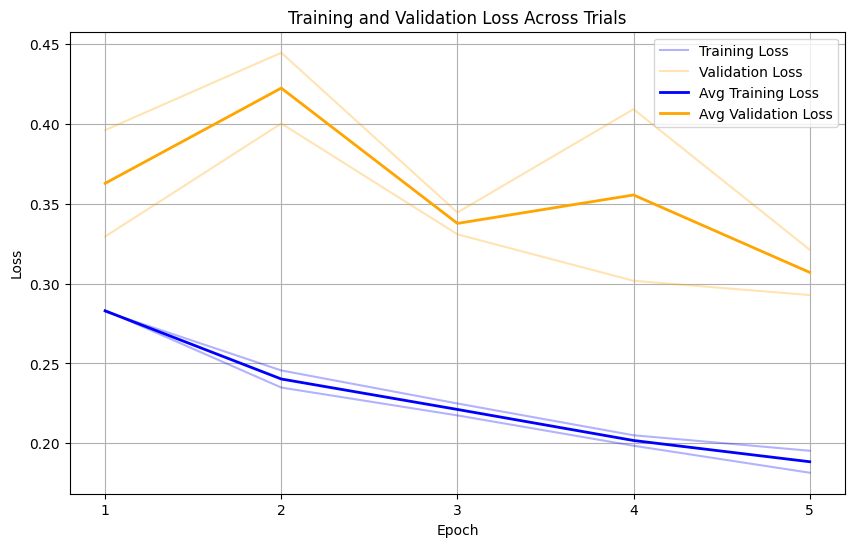

In [ ]:
# Train and plot
train_and_plot(train_loader, val_loader, create_googlenet_no_pretraining, criterion, optimizer_fn,
               device, num_epochs=5, n_trials=2, patience=3, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/No_pretraining_data_norm')

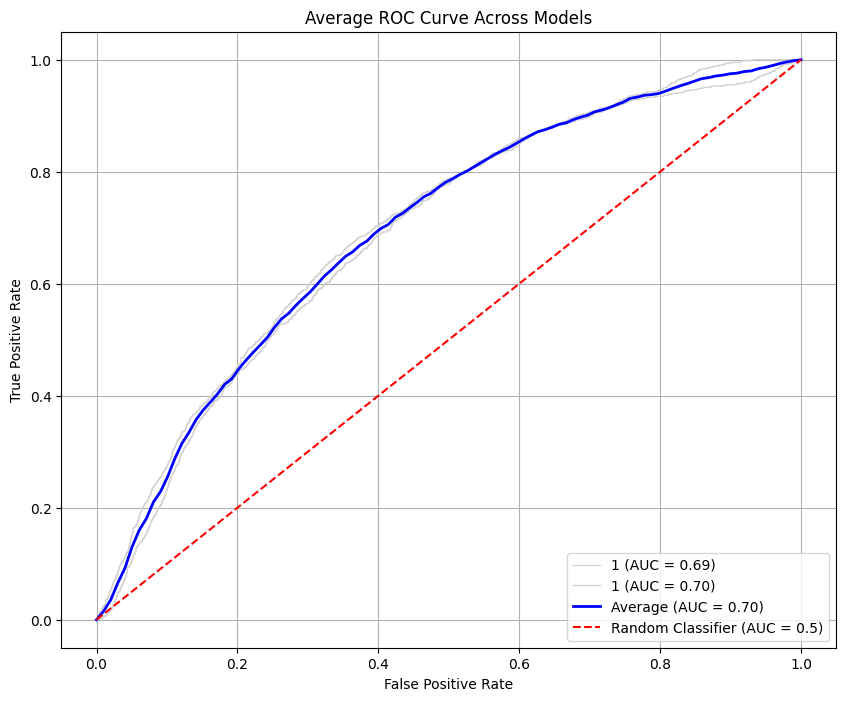

In [ ]:
googlenet1 = models.googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/No_pretraining_data_norm/GoogLeNet_trial_1_best.pth', weights_only=True))

googlenet2 = models.googlenet(weights="IMAGENET1K_V1")
googlenet2.fc = nn.Linear(googlenet2.fc.in_features, 2)
googlenet2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/No_pretraining_data_norm/GoogLeNet_trial_2_best.pth', weights_only=True))


my_models = [googlenet1, googlenet2]
for model in my_models:
    model = model.to(device)
labels = ["googlenet1", "googlenet2"]

plot_average_roc(my_models, val_loader, device, labels)

### Pretrained weights, training all the layers

Similar to the step 1 notebook. We have a validation loss of 0.2076, and an AUC of 0.91.

### Pretrained weights, freezing some layers

In [ ]:
# Define the final transformation pipeline with normalization (optional)
transform_data_norm = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 for GoogLeNet
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats to use pretrained weights
])

# Load the datasets again using the final transformation
train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform_data_norm)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform_data_norm)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer function
def optimizer_fn(params):
    return torch.optim.Adam(params, lr=1e-3)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Training the last 2 blocks

In [ ]:
def create_googlenet_unfreeze_2():
    # Load pre-trained GoogLeNet model
    model = models.googlenet(weights="IMAGENET1K_V1")

    # Modify the classifier to have 2 output classes
    model.fc = nn.Linear(model.fc.in_features, 2)

    # Initialize counters for frozen and trainable layers
    frozen_layers = 0
    trainable_layers = 0

    # Freeze all layers by default
    for param in model.parameters():
        param.requires_grad = False
        frozen_layers += 1  # Count frozen layers

    # Unfreeze the classifier's final layer
    for param in model.fc.parameters():
        param.requires_grad = True
        trainable_layers += 1  # Count the classifier layers as trainable

    # Unfreeze the parameters of the last inception block (e.g., Inception-5)
    for param in model.inception5a.parameters():
        param.requires_grad = True
        trainable_layers += 1  # Count these layers as trainable
    for param in model.inception5b.parameters():
        param.requires_grad = True
        trainable_layers += 1  # Count these layers as trainable

    # Print the number of frozen and trainable layers
    print(f"Number of frozen layers: {frozen_layers}")
    print(f"Number of layers to train: {trainable_layers}")

    return model

Number of frozen layers: 173
Number of layers to train: 38
Number of frozen layers: 173
Number of layers to train: 38
Trial 1, Epoch 1, Train Loss: 0.1806, Val Loss: 0.3161
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Unfreezing_2/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1428, Val Loss: 0.2989
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Unfreezing_2/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.1182, Val Loss: 0.3589
Trial 1, Epoch 4, Train Loss: 0.0962, Val Loss: 0.4232
Trial 1, Epoch 5, Train Loss: 0.0766, Val Loss: 0.3792
Early stopping triggered for Trial 1 at Epoch 5
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Unfreezing_2/GoogLeNet_trial_1.pth
Number of frozen layers: 173
Number of layers to tr

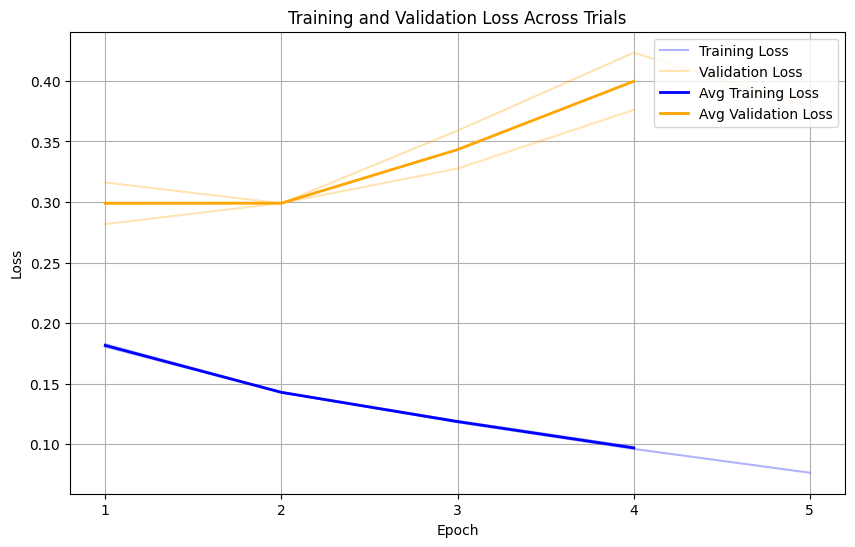

In [ ]:
# Train and plot
train_and_plot(train_loader, val_loader, create_googlenet_unfreeze_2, criterion, optimizer_fn,
               device, num_epochs=5, n_trials=2, patience=3, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Unfreezing_2')

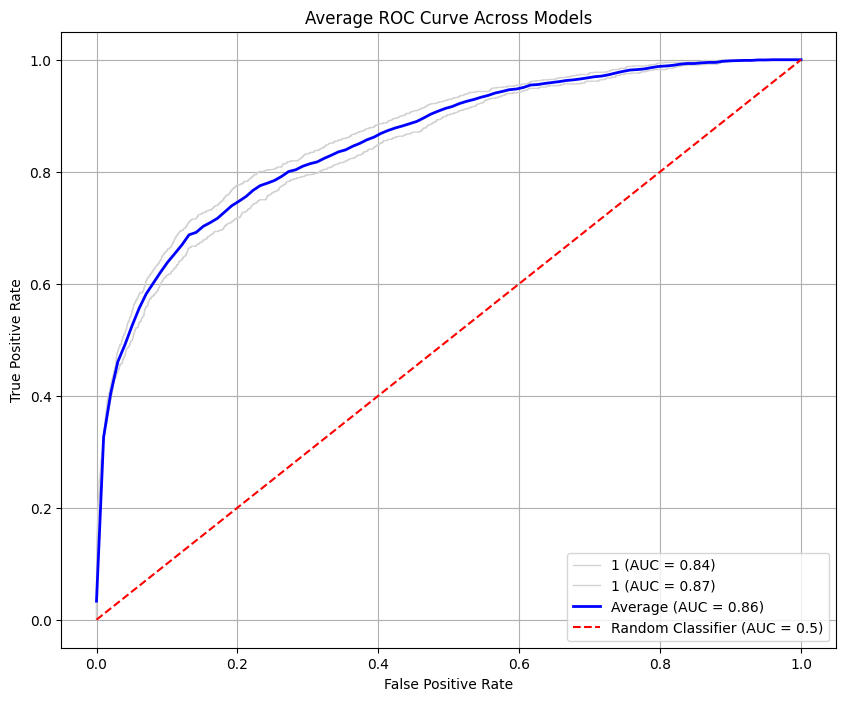

In [ ]:
googlenet1 = googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Unfreezing_2/GoogLeNet_trial_1_best.pth', weights_only=True))

googlenet2 = googlenet(weights="IMAGENET1K_V1")
googlenet2.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Unfreezing_2/GoogLeNet_trial_2_best.pth', weights_only=True))


my_models = [googlenet1, googlenet2]
for model in my_models:
    model = model.to(device)
labels = ["googlenet1", "googlenet2"]

plot_average_roc(my_models, val_loader, device, labels)

#### Training the last 5 blocks

In [ ]:
def create_googlenet_unfreeze_5():
    # Load pre-trained GoogLeNet model
    model = models.googlenet(weights="IMAGENET1K_V1")

    # Modify the classifier to have 2 output classes
    model.fc = nn.Linear(model.fc.in_features, 2)

    # Initialize counters for frozen and trainable layers
    frozen_layers = 0
    trainable_layers = 0

    # Freeze all layers by default
    for param in model.parameters():
        param.requires_grad = False
        frozen_layers += 1  # Count frozen layers

    # Unfreeze the classifier's final layer
    for param in model.fc.parameters():
        param.requires_grad = True
        trainable_layers += 1  # Count the classifier layers as trainable

    # Unfreeze the last 5 inception blocks
    # Includes inception4d, inception4e, inception5a, and inception5b
    for param in model.inception4d.parameters():
        param.requires_grad = True
        trainable_layers += 1  # Count these layers as trainable
    for param in model.inception4e.parameters():
        param.requires_grad = True
        trainable_layers += 1
    for param in model.inception5a.parameters():
        param.requires_grad = True
        trainable_layers += 1
    for param in model.inception5b.parameters():
        param.requires_grad = True
        trainable_layers += 1

    # Print the number of frozen and trainable layers
    print(f"Number of frozen layers: {frozen_layers}")
    print(f"Number of layers to train: {trainable_layers}")

    return model

Number of frozen layers: 173
Number of layers to train: 74
Number of frozen layers: 173
Number of layers to train: 74
Trial 1, Epoch 1, Train Loss: 0.1761, Val Loss: 0.3099
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Unfreezing_5/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1334, Val Loss: 0.2857
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Unfreezing_5/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.1006, Val Loss: 0.4236
Trial 1, Epoch 4, Train Loss: 0.0698, Val Loss: 0.4605
Trial 1, Epoch 5, Train Loss: 0.0484, Val Loss: 0.3297
Early stopping triggered for Trial 1 at Epoch 5
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Unfreezing_5/GoogLeNet_trial_1.pth
Number of frozen layers: 173
Number of layers to tr

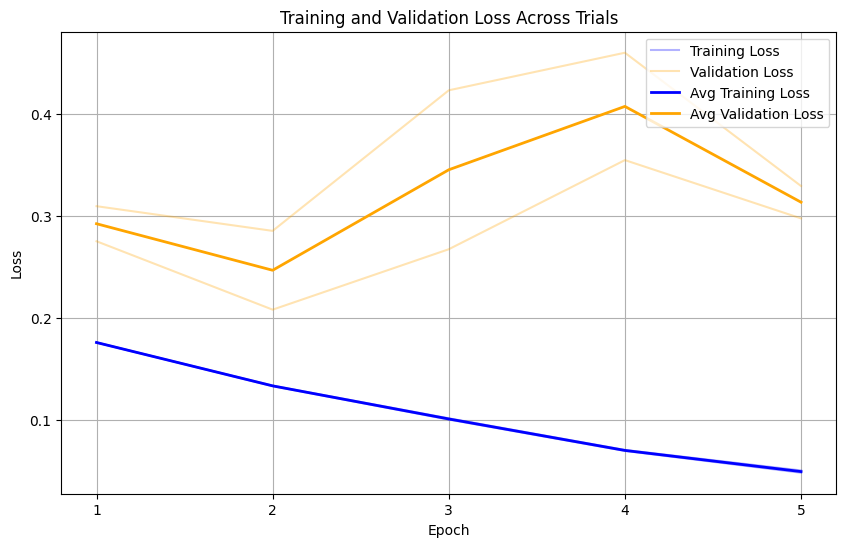

In [ ]:
# Train and plot
train_and_plot(train_loader, val_loader, create_googlenet_unfreeze_5, criterion, optimizer_fn,
               device, num_epochs=5, n_trials=2, patience=3, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Unfreezing_5')

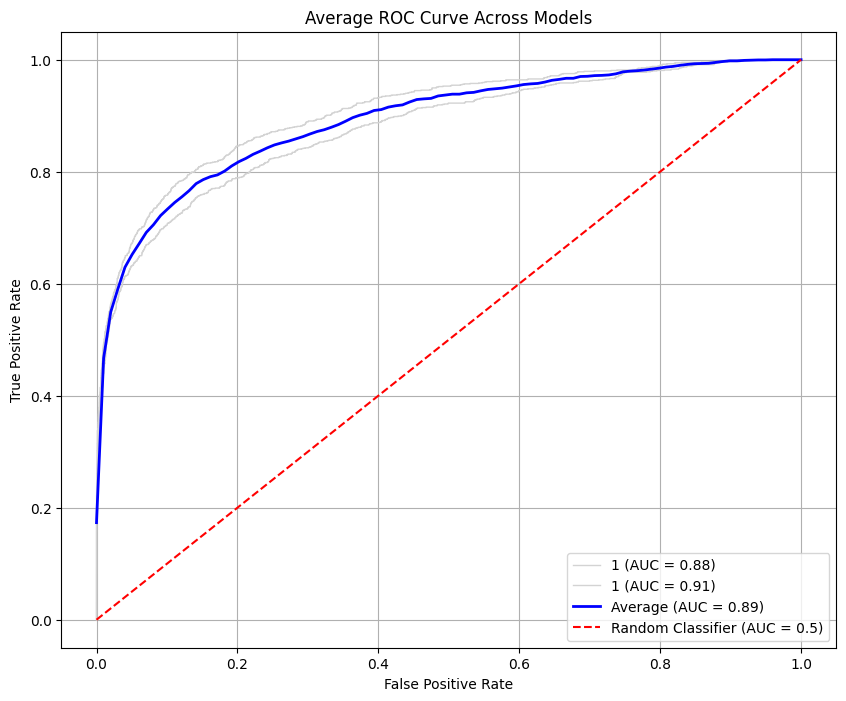

In [ ]:
googlenet1 = googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Unfreezing_5/GoogLeNet_trial_1_best.pth', weights_only=True))

googlenet2 = googlenet(weights="IMAGENET1K_V1")
googlenet2.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Unfreezing_5/GoogLeNet_trial_2_best.pth', weights_only=True))


my_models = [googlenet1, googlenet2]
for model in my_models:
    model = model.to(device)
labels = ["googlenet1", "googlenet2"]

plot_average_roc(my_models, val_loader, device, labels)

### Pretraining strategies : conclusion

The lowest loss and AUC were still obtained when no layer freezing was done.

## B) Training strategies

We want to try 2 popular ways to adress the data imbalance : balanced sampling (the probability of each image being sampled is inversely proportional to its class frequency) and class weighting (a higher weight in the loss is given to misclassifying the cracked images, inversely proportional to their frequency).

As the the sampling of images is now affected, we have a larger amount of epochs (10 instead of 5) and larger patience to help the training go over the majority of the data.

In this section, comparison is based only on the AUC, because the loss used for class weighting cannot be compared to the regular loss.

### Regular training

We can use the performance from the previous part to compare with the other 2 training strategies.

For regular training, we have a validation loss of 0.2076 and an AUC of 0.91.

### Balanced sampling

In [ ]:
# Define the final transformation pipeline with normalization (optional)
transform_data_norm = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 for ResNet
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats to use pretrained weights
])

# Load the datasets again using the final transformation
train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform_data_norm)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform_data_norm)

# Implement balanced sampling --------------------------------------------------
# Calculate class weights for balanced sampling
labels = [label for _, label in train_dataset.samples]
class_counts = torch.bincount(torch.tensor(labels))
class_weights = 1.0 / class_counts.float()

# Assign a weight to each sample based on its class
sample_weights = [class_weights[label] for _, label in train_dataset.samples]

# Create a WeightedRandomSampler for balanced sampling
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)
# ------------------------------------------------------------------------------

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer function
def optimizer_fn(params):
    return torch.optim.Adam(params, lr=1e-3)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Use the model with the previously selected pretraining strategy (ImageNet pretrained weights, training all the layers) :

In [ ]:
def create_googlenet_pretrained():
    # Load pre-trained MobileNetV2 model
    model = models.googlenet(weights="IMAGENET1K_V1")

    # Modify the classifier to have 2 output classes
    model.fc = nn.Linear(model.fc.in_features, 2)

    return model

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 164MB/s]


Trial 1, Epoch 1, Train Loss: 0.2915, Val Loss: 0.3175
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Balanced_sampling/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1689, Val Loss: 0.4067
Trial 1, Epoch 3, Train Loss: 0.0978, Val Loss: 0.3314
Trial 1, Epoch 4, Train Loss: 0.0624, Val Loss: 0.3238
Trial 1, Epoch 5, Train Loss: 0.0487, Val Loss: 0.7220
Early stopping triggered for Trial 1 at Epoch 5
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Balanced_sampling/GoogLeNet_trial_1.pth
Trial 2, Epoch 1, Train Loss: 0.2942, Val Loss: 0.3953
New best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Balanced_sampling/GoogLeNet_trial_2_best.pth
Trial 2, Epoch 2, Train Loss: 0.1809, Val Loss: 0.4097
Trial 2, Epoch 3, Train Loss: 0.1041, Val Lo

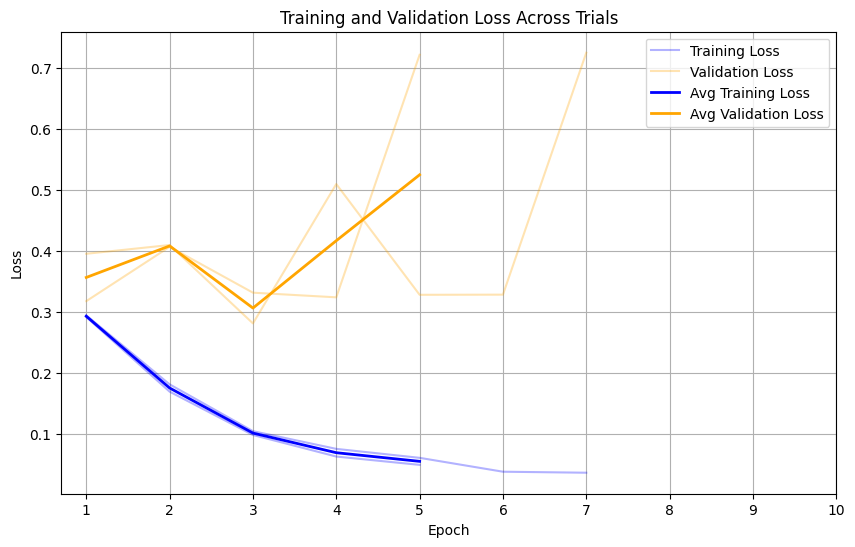

In [10]:
# Train and plot
train_and_plot(train_loader, val_loader, create_googlenet_pretrained, criterion, optimizer_fn,
               device, num_epochs=10, n_trials=2, patience=4, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Balanced_sampling')

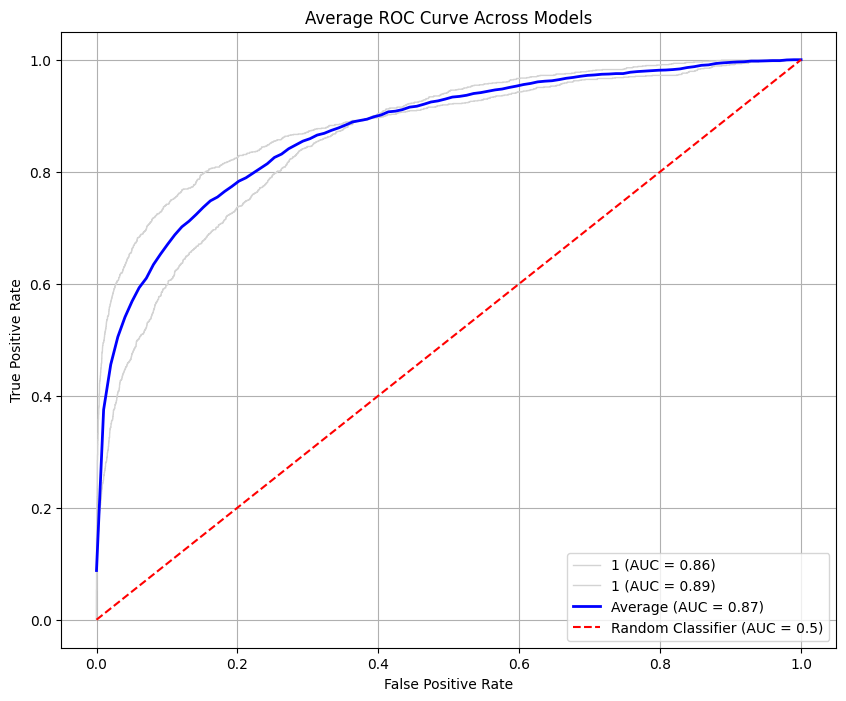

In [12]:
googlenet1 = googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Balanced_sampling/GoogLeNet_trial_1_best.pth', weights_only=True))

googlenet2 = googlenet(weights="IMAGENET1K_V1")
googlenet2.fc = nn.Linear(googlenet2.fc.in_features, 2)
googlenet2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Balanced_sampling/GoogLeNet_trial_2_best.pth', weights_only=True))


my_models = [googlenet1, googlenet2]
for model in my_models:
    model = model.to(device)
labels = ["googlenet1", "googlenet2"]

plot_average_roc(my_models, val_loader, device, labels)

### Class weighting

In [13]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the final transformation pipeline with normalization (optional)
transform_data_norm = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 for ResNet
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats to use pretrained weights
])

# Load the datasets again using the final transformation
train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform_data_norm)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform_data_norm)

# Implement class weighting --------------------------------------------------
# Calculate class weights for balanced sampling
labels = [label for _, label in train_dataset.samples]
class_counts = torch.bincount(torch.tensor(labels))
class_weights = 1.0 / class_counts.float()
class_weights = class_weights.to(device)

# Define criterion
criterion = nn.CrossEntropyLoss(weight=class_weights)
# ------------------------------------------------------------------------------

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define optimizer function
def optimizer_fn(params):
    return torch.optim.Adam(params, lr=1e-3)

In [14]:
def create_googlenet_pretrained():
    # Load pre-trained MobileNetV2 model
    model = models.googlenet(weights="IMAGENET1K_V1")

    # Modify the classifier to have 2 output classes
    model.fc = nn.Linear(model.fc.in_features, 2)

    return model

Trial 1, Epoch 1, Train Loss: 0.4039, Val Loss: 0.4010
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Class_weighting/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.3277, Val Loss: 0.2879
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Class_weighting/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.2784, Val Loss: 0.3347
Trial 1, Epoch 4, Train Loss: 0.2458, Val Loss: 0.3069
Trial 1, Epoch 5, Train Loss: 0.2101, Val Loss: 0.3000
Trial 1, Epoch 6, Train Loss: 0.1747, Val Loss: 0.4625
Early stopping triggered for Trial 1 at Epoch 6
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Class_weighting/GoogLeNet_trial_1.pth
Trial 2, Epoch 1, Train Loss: 0.3942, Val Loss: 0.4150
New best model for Trial 2 saved to /content/drive

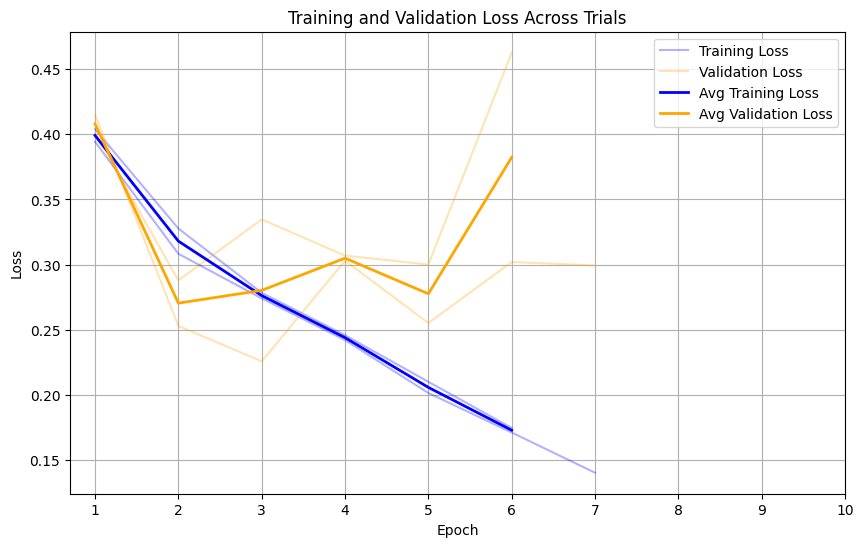

In [15]:
# Train and plot
train_and_plot(train_loader, val_loader, create_googlenet_pretrained, criterion, optimizer_fn,
               device, num_epochs=10, n_trials=2, patience=4, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Class_weighting')

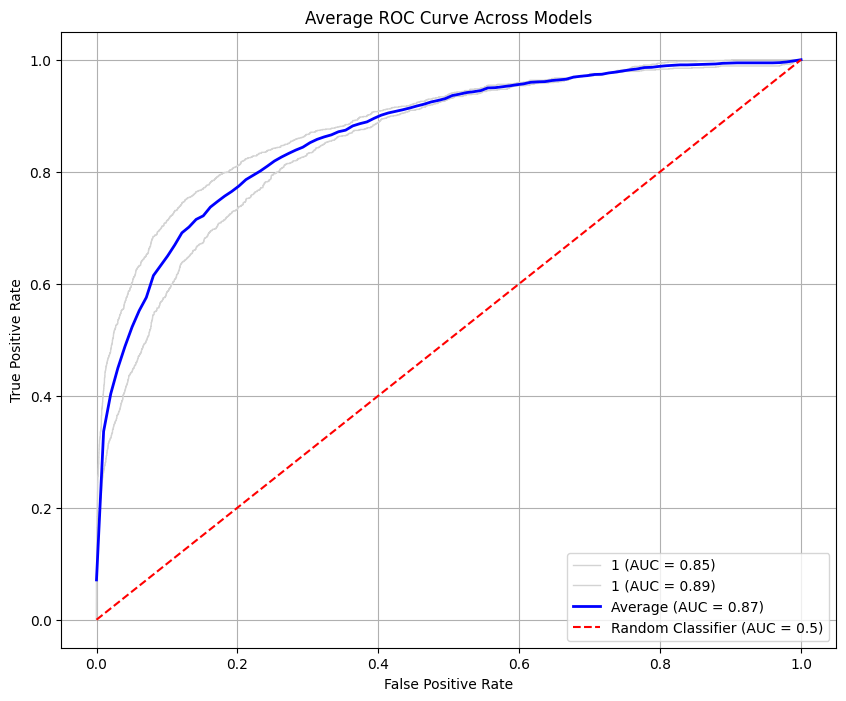

In [16]:
googlenet1 = googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Class_weighting/GoogLeNet_trial_1_best.pth', weights_only=True))

googlenet2 = googlenet(weights="IMAGENET1K_V1")
googlenet2.fc = nn.Linear(googlenet2.fc.in_features, 2)
googlenet2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_3_Pretraining_and_Training_strategies/Class_weighting/GoogLeNet_trial_2_best.pth', weights_only=True))


my_models = [googlenet1, googlenet2]
for model in my_models:
    model = model.to(device)
labels = ["googlenet1", "googlenet2"]

plot_average_roc(my_models, val_loader, device, labels)

### Training strategies : conclusion